In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns
import glob
from sklearn.model_selection import train_test_split
import lightgbm
import datetime
import math
from scipy import stats
import warnings
from itertools import chain, repeat
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
rcParams['figure.figsize'] = (16, 8)
rc('font', family='AppleGothic')

In [27]:
tr_base_path = './data/train'
te_base_path = './data/test'
submission_path = './submission'
infer_path = './inferencedata'
train_path = './trainingdata'
cv_lb_path = './cv_lb_path'

In [28]:
train = pd.read_csv(os.path.join(tr_base_path,'train.csv'))
submission = pd.read_csv('./data/sample_submission.csv')
# 파일명 불러오는 것: os.listdir과 다른점은 경로를 그대로 붙여서 불러와줌
# test_files = glob.glob('./data/test/*.csv')

# test load 
t_test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    t_test.append(temp)
    
test = pd.concat(t_test)
df_test = test.copy()

# p-pro

In [29]:
def base_preprocess(data, n, n2) : 
    
    # 원래 방법대로 한다면, 마지막 48개행은 target2에 대해 미지의 값을 가진게 아닌가?
    # step1 : 하루 뒤, 이틀 뒤 target 값 가져오기 
    data['1day_after_target'] = data.shift(n)['TARGET']
    data['2day_after_target'] = data.shift(n2)['TARGET']
    
    # step2 : 7일간의 segment를 할당하여 예측을 진행 
    
    data = data.dropna(axis=0)
    
    return(data)

In [30]:
df_train = base_preprocess(train, -48, -96)
df_train_day23 = base_preprocess(train, -96, -144)

# 필령's FE

In [31]:
test_day = df_test['Day'].copy() 

label_list = []

for i in range(1,568) : 
    label_list.append([i]*48)

label_list = [item for sublist in label_list for item in sublist]

In [32]:
def zenith_angel_def(data, merge_data, is_train=True, label_lists=None) : 
    
    if is_train != True : 
        
        data['Day'] = label_list
        merge_data['Day'] = label_list
    
    # 시간 및 분을 합쳐주는 함수
    def time_pil(data) : 

        texts = str(data['Hour']) + str(data['Minute'])[:1]

        return(texts)

    data['GHI_less'] = data['DHI'] + data['DNI']
    data['Time'] = data[['Hour','Minute']].apply(lambda x: time_pil(x), axis=1)
    data['GHI_less'] = data['GHI_less'].astype('int') 

    f = data[data['GHI_less']>0].groupby(['Day']).head(1)[['Day','Time','T','GHI_less']]
    f.columns = ['Day','First_time','First_T','First_GHI_less']

    l = data[data['GHI_less']>0].groupby(['Day']).tail(1)[['Day','Time','T','GHI_less']]
    l.columns = ['Day','Last_time','Last_T','Last_GHI_less']
    
    f_l = pd.merge(f, l, how='inner', on=['Day']) 
    
    def sun_hour(data) : 

        hours = (int(str(data['Last_time'])[:2]) - int(str(data['First_time'])[0]))*60

        return(hours)

    def sun_minute(data) : 

        minutes = (int(str(data['Last_time'][2])) - int(str(data['First_time'][1])))*10

        return(minutes)

    f_l['SUN_hour'] = f_l[['First_time','Last_time']].apply(lambda x:sun_hour(x), axis=1)
    f_l['SUN_minute'] = f_l[['First_time','Last_time']].apply(lambda x:sun_minute(x), axis=1)
    
    f_l['SUN_time'] = f_l['SUN_hour'] + f_l['SUN_minute']
    
    temp = pd.merge(data, f_l, how='inner', on='Day')
    temp['Time'] = temp[['Hour','Minute']].apply(lambda x: time_pil(x), axis=1)
    temp[['Time','First_time','Last_time']] = temp[['Time','First_time','Last_time']].astype('int')
    
    temp2 = temp[(temp['Time']>=temp['First_time']) & (temp['Time']<=temp['Last_time'])]  
    
    zenith_angle_lists = []

    for day in temp2.Day.unique() : 

        temp3 = temp2[temp2['Day']==day]
        zenith_angles = np.arange(0,181,180/(temp3['SUN_time'].iloc[0]/30))

        for num in range(len(zenith_angles)) : 

            if zenith_angles[num] < 90 : 
                zenith_angles[num] = 90 - zenith_angles[num]
                
            elif zenith_angles[num] == 0 :
                zenith_angles[num] = 1

            else : 
                zenith_angles[num] = zenith_angles[num] - 90

        zenith_angle_lists.append(zenith_angles)
        
    zenith_angle_lists = [item for sublist in zenith_angle_lists for item in sublist]
    temp2['zenith_angle'] = zenith_angle_lists
    
    final = pd.merge(merge_data, temp2[['Day','Hour','Minute','zenith_angle']],
                    how='left', on=['Day','Hour','Minute'])
    
    final = final.fillna(90) 
    
    final = pd.merge(final, temp2[['Day','SUN_time']].drop_duplicates(),
                    how='inner', on=['Day'])
    
    return(final)

In [33]:
df_train = zenith_angel_def(data = df_train, merge_data = df_train
                            , is_train=True, label_lists=None)

df_train_day23 = zenith_angel_def(data = df_train_day23, merge_data = df_train_day23
                            , is_train=True, label_lists=None)

df_test = zenith_angel_def(data = df_test, merge_data = df_test
                            , is_train=False, label_lists=label_list)

In [34]:
def custom_ghi(data) : 
    
    answer = data['DHI'] + (data['DNI']*math.cos(data['zenith_angle']))
    
    return answer 

df_train['GHI'] = df_train[['DHI','DNI','zenith_angle']].apply(lambda x: custom_ghi(x), axis=1)
df_train_day23['GHI'] = df_train_day23[['DHI','DNI','zenith_angle']].apply(lambda x: custom_ghi(x), axis=1)
df_test['GHI'] = df_test[['DHI','DNI','zenith_angle']].apply(lambda x: custom_ghi(x), axis=1)

print('df_train shape :', df_train.shape)
print('df_test shape :', df_test.shape)

df_train shape : (52464, 16)
df_test shape : (27216, 14)


In [35]:
df_test['Day'] = test_day.values

In [36]:
def train_2day_variable(df_train, rolling_num) : 
    
    hour_lists = []

    numbers = list(np.arange(0,24,1))
    n_list = [2]*24

    hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

    for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 

        hour_lists.append(df_train[(df_train['Hour']==hours) & (df_train['Minute']==minutes)])

    for num in range(len(hour_lists)) : 

        hour_lists[num][f'{rolling_num}days_mean_DHI'] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
        hour_lists[num][f'{rolling_num}days_mean_DNI'] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()
        #hour_lists[num][f'{rolling_num}days_mean_RH'] = hour_lists[num]['RH'].rolling(rolling_num).mean()
        hour_lists[num][f'{rolling_num}days_mean_WS'] = hour_lists[num]['WS'].rolling(rolling_num).mean() 
        hour_lists[num][f'{rolling_num}days_mean_TARGET'] = hour_lists[num]['TARGET'].rolling(rolling_num).mean()
        hour_lists[num][f'{rolling_num}days_mean_SUN_time'] = hour_lists[num]['SUN_time'].rolling(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_zenith_angle'] = hour_lists[num]['zenith_angle'].rolling(rolling_num).mean()
        hour_lists[num][f'{rolling_num}days_mean_GHI'] = hour_lists[num]['GHI'].rolling(rolling_num).mean()
        
        # expanding
#         hour_lists[num][f'{rolling_num}days_mean_DHI_expand'] = hour_lists[num]['DHI'].expanding(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_DNI_expand'] = hour_lists[num]['DNI'].expanding(rolling_num).mean()
#         #hour_lists[num][f'{rolling_num}days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()
#         #hour_lists[num][f'{rolling_num}days_mean_RH'] = hour_lists[num]['RH'].rolling(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_WS_expand'] = hour_lists[num]['WS'].expanding(rolling_num).mean() 
#         hour_lists[num][f'{rolling_num}days_mean_TARGET_expand'] = hour_lists[num]['TARGET'].expanding(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_SUN_time_expand'] = hour_lists[num]['SUN_time'].expanding(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_zenith_angle_expand'] = hour_lists[num]['zenith_angle'].expanding(rolling_num).mean()
#         hour_lists[num][f'{rolling_num}days_mean_GHI_expand'] = hour_lists[num]['GHI'].expanding(rolling_num).mean()

        # diff 변수 추가
#         hour_lists[num]['2days_mean_DHI{}_diff'.format(rolling_num)] = hour_lists[num]['DHI']-hour_lists[num][f'{rolling_num}days_mean_DHI']
#         hour_lists[num]['2days_mean_DNI{}_diff'.format(rolling_num)] = hour_lists[num]['DNI']-hour_lists[num][f'{rolling_num}days_mean_DNI']
#         hour_lists[num]['2days_mean_T{}_diff'.format(rolling_num)] = hour_lists[num]['T']-hour_lists[num]['T'].rolling(rolling_num).mean()
# #         hour_lists[num]['2days_mean_WS{}_diff'.format(rolling_num)] = hour_lists[num]['WS']-hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)]
# #         hour_lists[num]['2days_mean_RH{}_diff'.format(rolling_num)] = hour_lists[num]['RH']-hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)]
#         hour_lists[num]['2days_mean_TARGET{}_diff'.format(rolling_num)] = hour_lists[num]['TARGET']-hour_lists[num][f'{rolling_num}days_mean_TARGET']
#         hour_lists[num]['2days_mean_SUN_time{}_diff'.format(rolling_num)] = hour_lists[num]['SUN_time']-hour_lists[num][f'{rolling_num}days_mean_SUN_time']
#         hour_lists[num]['2days_mean_zenith_angle{}_diff'.format(rolling_num)] = hour_lists[num]['zenith_angle']-hour_lists[num][f'{rolling_num}days_mean_zenith_angle']
#         hour_lists[num]['2days_mean_GHI{}_diff'.format(rolling_num)] = hour_lists[num]['GHI']-hour_lists[num][f'{rolling_num}days_mean_GHI']
        

    df_train = pd.concat(hour_lists).sort_index() 
    
    return(df_train)

In [37]:
df_train = train_2day_variable(df_train, rolling_num=3)
df_train_day23 = train_2day_variable(df_train_day23, rolling_num=3)

In [38]:
def test_2day_variable(df_test, rolling_num) : 
    
    label_list = []

    for i in range(81) : 
        label_list.append([i]*336)

    label_list = [item for sublist in label_list for item in sublist]

    df_test['label'] = label_list 

    test_dataset = []

    for label_num in df_test.label.unique() : 

        hour_lists = []
        numbers = list(np.arange(0,24,1))
        n_list = [2]*24
        df_test2 = df_test[df_test['label']==label_num]

        hours_range = list(chain.from_iterable((repeat(number, n) for (number, n) in zip(numbers, n_list))))

        for (hours,minutes) in zip(hours_range,list(np.arange(0,31,30))*30) : 
            
            hour_lists.append(df_test2[(df_test2['Hour']==hours) & (df_test2['Minute']==minutes)])

        for num in range(len(hour_lists)) : 
            
            hour_lists[num][f'{rolling_num}days_mean_DHI'] = hour_lists[num]['DHI'].rolling(rolling_num).mean()
            hour_lists[num][f'{rolling_num}days_mean_DNI'] = hour_lists[num]['DNI'].rolling(rolling_num).mean()
            #hour_lists[num][f'{rolling_num}days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()
            #hour_lists[num][f'{rolling_num}days_mean_RH'] = hour_lists[num]['RH'].rolling(rolling_num).mean()
            hour_lists[num][f'{rolling_num}days_mean_WS'] = hour_lists[num]['WS'].rolling(rolling_num).mean()
            hour_lists[num][f'{rolling_num}days_mean_TARGET'] = hour_lists[num]['TARGET'].rolling(rolling_num).mean()
            hour_lists[num][f'{rolling_num}days_mean_SUN_time'] = hour_lists[num]['SUN_time'].rolling(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_zenith_angle'] = hour_lists[num]['zenith_angle'].rolling(rolling_num).mean()
            hour_lists[num][f'{rolling_num}days_mean_GHI'] = hour_lists[num]['GHI'].rolling(rolling_num).mean()
            
            # expanding 성능 엄청 나빠짐...
#             hour_lists[num][f'{rolling_num}days_mean_DHI_expand'] = hour_lists[num]['DHI'].expanding(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_DNI_expand'] = hour_lists[num]['DNI'].expanding(rolling_num).mean()
#             #hour_lists[num][f'{rolling_num}days_mean_T'] = hour_lists[num]['T'].rolling(rolling_num).mean()
#             #hour_lists[num][f'{rolling_num}days_mean_RH'] = hour_lists[num]['RH'].rolling(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_WS_expand'] = hour_lists[num]['WS'].expanding(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_TARGET_expand'] = hour_lists[num]['TARGET'].expanding(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_SUN_time_expand'] = hour_lists[num]['SUN_time'].expanding(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_zenith_angle_expand'] = hour_lists[num]['zenith_angle'].expanding(rolling_num).mean()
#             hour_lists[num][f'{rolling_num}days_mean_GHI_expand'] = hour_lists[num]['GHI'].expanding(rolling_num).mean()
            
            # diff 변수 추가 -> 단일 성능은 좋아졌는데, 앙상블에서 성능이 떨어짐
#             hour_lists[num]['2days_mean_DHI{}_diff'.format(rolling_num)] = hour_lists[num]['DHI']-hour_lists[num][f'{rolling_num}days_mean_DHI']
#             hour_lists[num]['2days_mean_DNI{}_diff'.format(rolling_num)] = hour_lists[num]['DNI']-hour_lists[num][f'{rolling_num}days_mean_DNI']
#             hour_lists[num]['2days_mean_T{}_diff'.format(rolling_num)] = hour_lists[num]['T']-hour_lists[num]['T'].rolling(rolling_num).mean()
#     #         hour_lists[num]['2days_mean_WS{}_diff'.format(rolling_num)] = hour_lists[num]['WS']-hour_lists[num]['2days_mean_WS_rolling{}'.format(rolling_num)]
#     #         hour_lists[num]['2days_mean_RH{}_diff'.format(rolling_num)] = hour_lists[num]['RH']-hour_lists[num]['2days_mean_RH_rolling{}'.format(rolling_num)]
#             hour_lists[num]['2days_mean_TARGET{}_diff'.format(rolling_num)] = hour_lists[num]['TARGET']-hour_lists[num][f'{rolling_num}days_mean_TARGET']
#             hour_lists[num]['2days_mean_SUN_time{}_diff'.format(rolling_num)] = hour_lists[num]['SUN_time']-hour_lists[num][f'{rolling_num}days_mean_SUN_time']
#             hour_lists[num]['2days_mean_zenith_angle{}_diff'.format(rolling_num)] = hour_lists[num]['zenith_angle']-hour_lists[num][f'{rolling_num}days_mean_zenith_angle']
#             hour_lists[num]['2days_mean_GHI{}_diff'.format(rolling_num)] = hour_lists[num]['GHI']-hour_lists[num][f'{rolling_num}days_mean_GHI']

        temp = pd.concat(hour_lists)
        test_dataset.append(temp)
        
    df_test = pd.concat(test_dataset).reset_index().sort_values(['label','index'])
    df_test = df_test.drop(['index'],axis=1).reset_index(drop=True) 
    
    return(df_test)

In [39]:
df_test = test_2day_variable(df_test, rolling_num=3)

In [126]:
# expanding rolling


# final p-pro

In [40]:
df_train = df_train[df_train['RH']!=100]
df_train_day23 = df_train_day23[df_train_day23['RH']!=100]

In [41]:
df_train = df_train.dropna()
df_train = df_train.drop(['Day','Minute','GHI_less','Time'], axis=1)

df_train_day23 = df_train_day23.dropna()
df_train_day23 = df_train_day23.drop(['Day','Minute','GHI_less','Time'], axis=1)

df_test = df_test.dropna()

df_test2 = df_test[df_test['Day']==6]
df_test2 = df_test2.drop(['Day','Minute','GHI_less','Time'], axis=1)

df_test_day23 = df_test[df_test['Day']==5]
df_test_day23 = df_test_day23.drop(['Day','Minute','GHI_less','Time'], axis=1)

df_test2 = df_test2.drop(['label'],axis=1)
df_test_day23 = df_test_day23.drop(['label'],axis=1)

print('df_train shape :', df_train.shape)
print('df_test shape :', df_test.shape)

df_train shape : (51142, 18)
df_test shape : (19440, 21)


In [65]:
# # minute도 포함해서 한번 진행해보기
# df_train = df_train.dropna()
# df_train = df_train.drop(['Minute','Day'], axis=1)
# # df_train = df_train.drop(['Day'], axis=1)

# df_train_day23 = df_train_day23.dropna()
# df_train_day23 = df_train_day23.drop(['Minute','Day'], axis=1)
# # df_train_day23 = df_train_day23.drop(['Day'], axis=1)

# df_test = df_test.dropna()
# df_test2 = df_test[df_test['Day']==6]
# df_test2 = df_test2.drop(['Day','Minute'], axis=1)

# df_test_day23 = df_test[df_test['Day']==5]
# df_test_day23 = df_test_day23.drop(['Day','Minute'], axis=1)

# df_test2 = df_test2.drop(['label'],axis=1)
# df_test_day23 = df_test_day23.drop(['label'],axis=1)

In [42]:
X_test = df_test2
X_test_day23 = df_test_day23

In [44]:
df_train.drop(columns = 'zenith_angle', inplace = True)
df_train_day23.drop(columns = 'zenith_angle', inplace = True)
X_test.drop(columns = 'zenith_angle', inplace = True)
X_test_day23.drop(columns = 'zenith_angle', inplace = True)

# Save

In [45]:
time_str = datetime.datetime.strftime(
    datetime.datetime.today(),
    '%Y%m%d_%H%M%S'
)
print(time_str)
df_train.to_csv(
    os.path.join(train_path, f'training_{time_str}.csv'), 
    index=False
)

X_test.to_csv(
    os.path.join(infer_path, f'inference_{time_str}.csv'), 
    index=False
)

20210118_235922


In [46]:
df_train_day23.to_csv(
    os.path.join(train_path, f'training_{time_str}_day23.csv'), 
    index=False
)

X_test_day23.to_csv(
    os.path.join(infer_path, f'inference_{time_str}_day23.csv'), 
    index=False
)

# correlation EDA

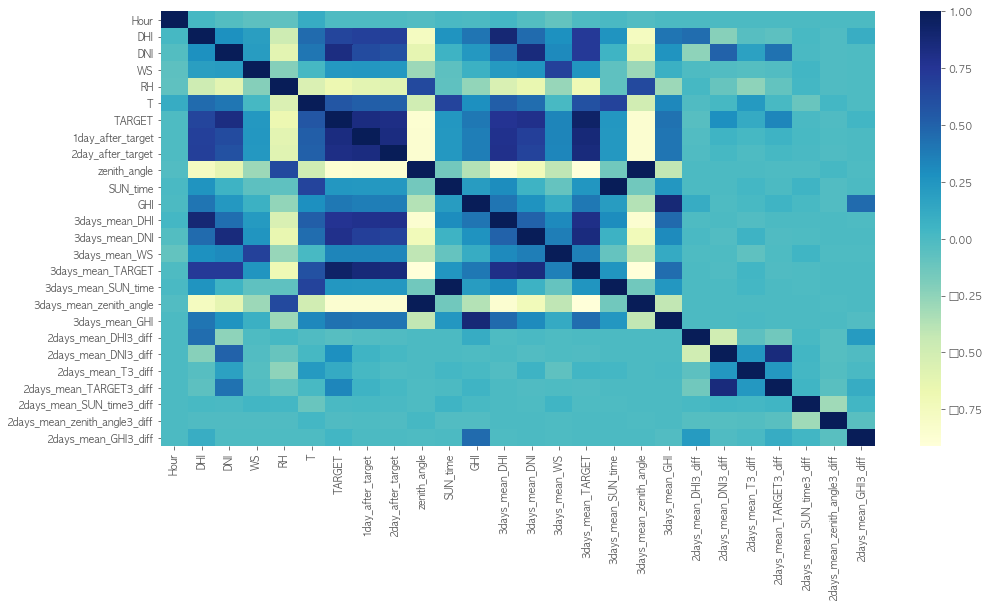

In [25]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')

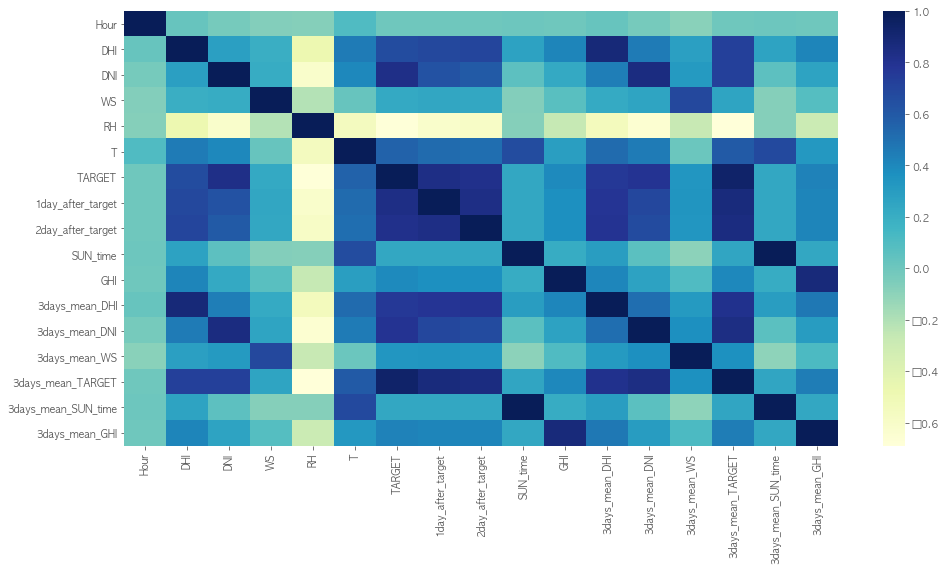

In [47]:
sns.heatmap(df_train.corr(), cmap='YlGnBu')